# getSHAP

This script generates mean |SHAP| values from SHAP results of fold 1-10 for the three traits mass, wing and tarsus.

Second part generates cumulative feature importance plot.

NB! Need to use python 3.11 when using package shap. Not compatible yet with python 3.13, as of 06.05.25.

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\gard_\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Globally defined trait
trait = "mass"

In [17]:
data = pd.read_feather(f"C:/Users/gard_/Documents/MasterThesis/Code/Data/Processed/{trait}BV_70k.feather")
df = pd.read_csv(f'C:/Users/gard_/Documents/MasterThesis/Code/Data/CVfolds/cv_folds_{trait}_70k.csv')
data_models = pd.read_csv(f"C:/Users/gard_/Documents/MasterThesis/Code/Models/70k/{trait}_70k_params.csv")

Load SHAP models

In [18]:
mods = np.empty(10, dtype=object)

# Loop through each row to create and store the model
for i in range(len(data_models)):
    row = data_models.iloc[i]
    
    # Initialize the model with parameters from the current row
    model = xgb.XGBRegressor(
        n_estimators=600,
        learning_rate=row['learning_rate'],
        max_depth=int(row['max_depth']),  
        subsample=row['subsample'],
        colsample_bytree=row['colsample_bytree'],
        min_child_weight=int(row['min_child_weight'])
    )
    
    # Store the model in the numpy array
    mods[i] = model

In [19]:
X_CV = data.drop([
            "ID",
            "mean_pheno",
            "IID",
            "MAT",
            "PAT",
            "SEX",
            "PHENOTYPE",
            "hatchisland"
        ], axis = 1)

X_CV = X_CV.fillna(0)
# Change from float to int64 for all columns not 'ringnr' (i.e. all SNPs)
X_temp = X_CV.drop(['ringnr'], axis = 1)
X_temp = X_temp.T.astype('int64').T
X_temp.insert(0, 'ringnr', X_CV['ringnr'])
X_CV = X_temp

# y is ringnrs + pseudo phenotype
y_CV = data[['ID', 'ringnr']]

In [20]:
shap_list = []

In [21]:
def get_shap():
    for i in range(1,11):
        print("Starting run ", i, "\n")
        test_idx = df[(df['Fold'] == i) & (df['Set'] == 'test')]['ringnr'].values
        train_val_idx = df[(df['Fold'] == i) & (df['Set'] == 'train')]['ringnr'].values
        X_train_val = X_CV[X_CV["ringnr"].isin(train_val_idx)].drop(["ringnr",],axis = 1)
        y_train_val = y_CV[y_CV['ringnr'].isin(train_val_idx)].drop(["ringnr",], axis = 1)
        X_test = X_CV[X_CV["ringnr"].isin(test_idx)].drop(["ringnr",], axis = 1)

        model = mods[i-1]
        model.fit(X_train_val, y_train_val, verbose = False)
        explainer = shap.TreeExplainer(model)
        shap_value = explainer.shap_values(X_test) # (n/10 x p)
        shap_list.append(shap_value)
    return(shap_list)

In [22]:
shap_list = get_shap() # (n x p)

Starting run  1 

Starting run  2 

Starting run  3 

Starting run  4 

Starting run  5 

Starting run  6 

Starting run  7 

Starting run  8 

Starting run  9 

Starting run  10 



In [23]:
mean_shap = np.abs(np.concatenate(shap_list, axis=0)).mean(axis=0) # (p x 1), mean over the indvs

In [24]:
if mean_shap.ndim == 2:
    mean_shap = mean_shap.flatten()

# Save to be further manipulated in Chromosome2Manhattan.R
shap_df = pd.DataFrame(mean_shap.reshape(1,-1), columns=X_CV.drop(["ringnr"], axis = 1).columns) # (p x 1), Values for Manhattan
feather.write_feather(shap_df, f'C:/Users/gard_/Documents/MasterThesis/Code/Results/70k/SHAP/shap_{trait}_70k.feather')

# Cumulative feature importance combined all traits

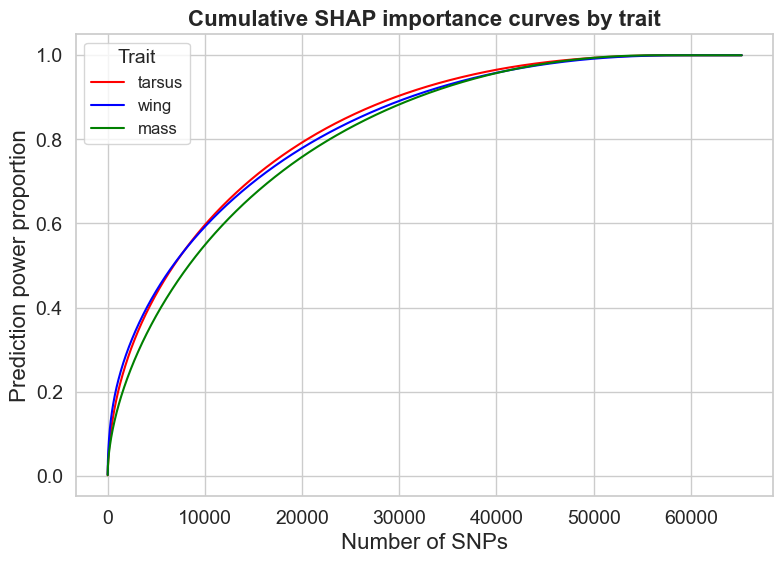

In [3]:
# Define traits and corresponding file paths
traits = ["tarsus", "wing", "mass"]
colors = ["red", "blue", "green"]  # Different colors for each trait

# Initialize a list to collect data for all traits
all_data = []

# Loop through each trait and compute cumulative deviation
for trait in traits:
    shap_values = pd.read_feather(f"C:/Users/gard_/Documents/MasterThesis/Code/Results/70k/SHAP/shap_{trait}_70k.feather")

    # Compute standardized SHAP importance
    deviations = -np.sort(-np.sum(np.abs(shap_values), axis=0))
    deviations = deviations / deviations.sum()

    # Compute cumulative importance
    cumulative_deviations = np.cumsum(deviations)
    n_subset = len(deviations)
    x_vals = np.linspace(0, n_subset, n_subset)

    # Store results in dataframe
    df = pd.DataFrame({
        "Number of SNPs": x_vals,
        "Proportion of deviation": cumulative_deviations,
        "Trait": trait
    })
    all_data.append(df)

# Combine all trait data
combined_data = pd.concat(all_data, ignore_index=True)

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Plot
plt.figure(figsize=(9, 6))
sns.lineplot(data=combined_data, x="Number of SNPs", y="Proportion of deviation", hue="Trait", palette=colors)
plt.title("Cumulative SHAP importance curves by trait", fontsize=16, weight="bold")
plt.xlabel("Number of SNPs", fontsize=16)
plt.ylabel("Prediction power proportion", fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.legend(title="Trait", title_fontsize=14, fontsize=12)

# Save and show
plt.savefig("C:/Users/gard_/Documents/MasterThesis/Code/Figures/CFI_SHAP_real.pdf", dpi=300, bbox_inches="tight")
plt.show()